# Plotting sea ice 

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.path as mpath
import numpy as np
%matplotlib inline

# To costumise subplots
import matplotlib.gridspec as gridspec

#import glob

#import xesmf
#import os
#import pandas as pd
#import calendar
#from tqdm import tqdm_notebook
from datetime import timedelta

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40139,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:46205,Total threads: 4
Dashboard: /proxy/42563/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:45115,


In [3]:
session_CM2  = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
expt_CM2_1   = 'bz687'

In [4]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_gadi'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

If you get a 'read-only database' warning, it is because the database has not finished building. 

In [5]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'
fig_path     = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

In [6]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})
month_label = ['J','F','M','A','M','J','J','A','S','O','N','D']

### Grid information

In [7]:
area_t025 = cc.querying.getvar(expt_OM2_025, 'area_t', session_OM2, n=1)
area_t1   = cc.querying.getvar(expt_OM2_1, 'area_t', session_OM2, n=1)

In [8]:
geolon_t025 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t025 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

In [44]:
geolon_t1 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc').geolon_t
geolat_t1 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc').geolat_t

### Observations

Sea ice concentration is previously interpolated onto OM2 grid in `Calc_NSIDC_sic_onto_OM2_grid.ipynb`.

In [9]:
NH_sic_obs = xr.open_dataarray('/g/data/x77/wgh581/Post_Process/Observations/' + 'NSIDC_sic_1979_2019_monthly_NH_grid_OM2_025.nc')
SH_sic_obs = xr.open_dataarray('/g/data/x77/wgh581/Post_Process/Observations/' + 'NSIDC_sic_1979_2019_monthly_SH_grid_OM2_025.nc')

Sea ice concentration in peak season

In [11]:
# # NH: March
# NH_sic_obs_Mar = NH_sic_obs[({"time": NH_sic_obs.time.dt.month == 3})]
# # SH: Sep
# SH_sic_obs_Sep = SH_sic_obs[({"time": SH_sic_obs.time.dt.month == 9})]

Monthly sic climatology all years

In [110]:
NH_sic_obs_clim = NH_sic_obs.groupby('time.month').mean('time',skipna=True).sel(yt_ocean=slice(40, 90))
SH_sic_obs_clim = SH_sic_obs.groupby('time.month').mean('time',skipna=True).sel(yt_ocean=slice(-90, -40)) 

Monthly sea ice area/extend climatology, in km2

In [111]:
NH_sia_obs_clim = (NH_sic_obs_clim * area_t025.sel(yt_ocean=slice(40, 90))).sum('xt_ocean').sum('yt_ocean') * 1e-6
SH_sia_obs_clim = (SH_sic_obs_clim * area_t025.sel(yt_ocean=slice(-90, -40))).sum('xt_ocean').sum('yt_ocean') * 1e-6

In [112]:
NH_sia_obs_clim = NH_sia_obs_clim.load()
SH_sia_obs_clim = SH_sia_obs_clim.load()

Mean, max, min sea ice extent

In [15]:
print('Antarctic')
print('mean =', np.round(SH_sia_obs_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(SH_sia_obs_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(SH_sia_obs_clim.min().values*1e-6,2), '10^6 km^2')
print('')
print('Arctic')
print('mean =', np.round(NH_sia_obs_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(NH_sia_obs_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(NH_sia_obs_clim.min().values*1e-6,2), '10^6 km^2')

Antarctic
mean = 9.53 10^6 km^2
max = 15.98 10^6 km^2
min = 2.04 10^6 km^2

Arctic
mean = 9.41 10^6 km^2
max = 12.73 10^6 km^2
min = 5.15 10^6 km^2


**I haven't detrended the sea ice observations**

**No 0.15 sea ice coverage threshold**

For NH, change the lat, lon values (rotated pole)

In [113]:
NH_sic_obs_clim = NH_sic_obs_clim.assign_coords({'geolon_t': geolon_t025, 'geolat_t': geolat_t025})

### Model sea ice

Load sea ice concentration climatology (calculated further down in this script).

In [106]:
aice_CM2_025_NH_clim = xr.open_dataarray(path_to_data + 'aice_CM2_025_NH_clim_400_499.nc')
aice_CM2_025_SH_clim = xr.open_dataarray(path_to_data + 'aice_CM2_025_SH_clim_400_499.nc')

In [107]:
aice_OM2_025_NH_clim = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_025/aice_OM2_025_NH_clim_2300_2399.nc')
aice_OM2_025_SH_clim = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_025/aice_OM2_025_SH_clim_2300_2399.nc')

In [108]:
aice_OM2_1_NH_clim = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_1/aice_OM2_1_NH_clim_2300_2399.nc')
aice_OM2_1_SH_clim = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_1/aice_OM2_1_SH_clim_2300_2399.nc')

In [105]:
aice_CM2_1_NH_clim = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/aice_CM2_1_NH_clim_400_499.nc')
aice_CM2_1_SH_clim = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/aice_CM2_1_SH_clim_400_499.nc')

In [65]:
# test.geolat_t.values = geolat_t1.sel(yt_ocean=slice(40,90))
# test.geolon_t.values = geolon_t1.sel(yt_ocean=slice(40,90))

For NH, change the lat, lon values (rotated pole)

In [114]:
aice_CM2_025_NH_clim = aice_CM2_025_NH_clim.assign_coords({'geolon_t': geolon_t025, 'geolat_t': geolat_t025})
aice_CM2_1_NH_clim   = aice_CM2_1_NH_clim.assign_coords({'geolon_t': geolon_t1, 'geolat_t': geolat_t1})
aice_OM2_025_NH_clim = aice_OM2_025_NH_clim.assign_coords({'geolon_t': geolon_t025, 'geolat_t': geolat_t025})
aice_OM2_1_NH_clim   = aice_OM2_1_NH_clim.assign_coords({'geolon_t': geolon_t1, 'geolat_t': geolat_t1})

In [145]:
# Above code doesn't properly work for CM2-1 abd OM2-1 (gives nans only), assign geolon_t, geolat_t values per hand
aice_CM2_1_NH_clim.geolat_t.values = geolat_t1.sel(yt_ocean=slice(40,90))
aice_CM2_1_NH_clim.geolon_t.values = geolon_t1.sel(yt_ocean=slice(40,90))

aice_OM2_1_NH_clim.geolat_t.values = geolat_t1.sel(yt_ocean=slice(40,90))
aice_OM2_1_NH_clim.geolon_t.values = geolon_t1.sel(yt_ocean=slice(40,90))

Get sea ice extent

In [116]:
sie_CM2_025_NH_clim = (aice_CM2_025_NH_clim * area_t025.sel(yt_ocean=slice(40, 90))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_CM2_025_SH_clim = (aice_CM2_025_SH_clim * area_t025.sel(yt_ocean=slice(-90, -40))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_CM2_025_NH_clim = sie_CM2_025_NH_clim.load()
sie_CM2_025_SH_clim = sie_CM2_025_SH_clim.load()

In [146]:
sie_CM2_1_NH_clim = (aice_CM2_1_NH_clim * area_t1.sel(yt_ocean=slice(40, 90))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_CM2_1_SH_clim = (aice_CM2_1_SH_clim * area_t1.sel(yt_ocean=slice(-90, -40))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_CM2_1_NH_clim = sie_CM2_1_NH_clim.load()
sie_CM2_1_SH_clim = sie_CM2_1_SH_clim.load()

In [118]:
sie_OM2_025_NH_clim = (aice_OM2_025_NH_clim * area_t025.sel(yt_ocean=slice(40, 90))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_OM2_025_SH_clim = (aice_OM2_025_SH_clim * area_t025.sel(yt_ocean=slice(-90, -40))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_OM2_025_NH_clim = sie_OM2_025_NH_clim.load()
sie_OM2_025_SH_clim = sie_OM2_025_SH_clim.load()

In [119]:
sie_OM2_1_NH_clim = (aice_OM2_1_NH_clim * area_t1.sel(yt_ocean=slice(40, 90))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_OM2_1_SH_clim = (aice_OM2_1_SH_clim * area_t1.sel(yt_ocean=slice(-90, -40))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_OM2_1_NH_clim = sie_OM2_1_NH_clim.load()
sie_OM2_1_SH_clim = sie_OM2_1_SH_clim.load()

In [147]:
print('CM2-025')
print('Antarctic')
print('mean =', np.round(sie_CM2_025_SH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_CM2_025_SH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_CM2_025_SH_clim.min().values*1e-6,2), '10^6 km^2')
print('Arctic')
print('mean =', np.round(sie_CM2_025_NH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_CM2_025_NH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_CM2_025_NH_clim.min().values*1e-6,2), '10^6 km^2')
print('')
print('CM2-1')
print('Antarctic')
print('mean =', np.round(sie_CM2_1_SH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_CM2_1_SH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_CM2_1_SH_clim.min().values*1e-6,2), '10^6 km^2')
print('Arctic')
print('mean =', np.round(sie_CM2_1_NH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_CM2_1_NH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_CM2_1_NH_clim.min().values*1e-6,2), '10^6 km^2')
print('')
print('OM2-025')
print('Antarctic')
print('mean =', np.round(sie_OM2_025_SH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_OM2_025_SH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_OM2_025_SH_clim.min().values*1e-6,2), '10^6 km^2')
print('Arctic')
print('mean =', np.round(sie_OM2_025_NH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_OM2_025_NH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_OM2_025_NH_clim.min().values*1e-6,2), '10^6 km^2')
print('')
print('OM2-1')
print('Antarctic')
print('mean =', np.round(sie_OM2_1_SH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_OM2_1_SH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_OM2_1_SH_clim.min().values*1e-6,2), '10^6 km^2')
print('Arctic')
print('mean =', np.round(sie_OM2_1_NH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_OM2_1_NH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_OM2_1_NH_clim.min().values*1e-6,2), '10^6 km^2')
print('')

CM2-025
Antarctic
mean = 7.06 10^6 km^2
max = 12.91 10^6 km^2
min = 0.26 10^6 km^2
Arctic
mean = 10.74 10^6 km^2
max = 15.69 10^6 km^2
min = 4.59 10^6 km^2

CM2-1
Antarctic
mean = 8.01 10^6 km^2
max = 14.21 10^6 km^2
min = 0.65 10^6 km^2
Arctic
mean = 10.99 10^6 km^2
max = 15.72 10^6 km^2
min = 5.09 10^6 km^2

OM2-025
Antarctic
mean = 9.91 10^6 km^2
max = 15.76 10^6 km^2
min = 1.08 10^6 km^2
Arctic
mean = 10.45 10^6 km^2
max = 14.34 10^6 km^2
min = 5.02 10^6 km^2

OM2-1
Antarctic
mean = 9.04 10^6 km^2
max = 14.92 10^6 km^2
min = 0.75 10^6 km^2
Arctic
mean = 10.53 10^6 km^2
max = 14.6 10^6 km^2
min = 4.81 10^6 km^2



### Plot monthly climatology

In [121]:
CLEX_Red = '#DA1E48'
CLEX_Pink = '#F48580'
CLEX_SkyBlue = '#00BDF2'
CLEX_MidBlue = '#008DD0'
CLEX_CobaldBlue = '#0066B3'
CLEX_MidnightBlue = '#113559'
CLEX_Gray = '#4D4D47'

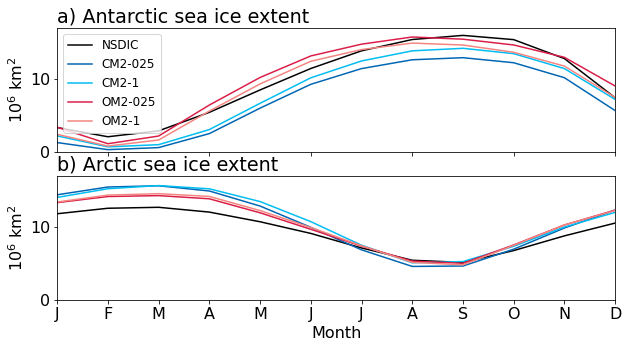

In [127]:
fig = plt.figure(figsize=(10,5))

plt.subplot(211)
(SH_sia_obs_clim*1e-6).plot(label='NSDIC', color='k')
(sie_CM2_025_SH_clim*1e-6).plot(label='CM2-025', color=CLEX_CobaldBlue)
(sie_CM2_1_SH_clim*1e-6).plot(label='CM2-1', color=CLEX_SkyBlue)
(sie_OM2_025_SH_clim*1e-6).plot(label='OM2-025', color=CLEX_Red)
(sie_OM2_1_SH_clim*1e-6).plot(label='OM2-1', color=CLEX_Pink)
plt.legend(ncol=1, fontsize=ft_size-4)
plt.xlim(1,12)
plt.ylim(0, 17)
plt.title('a) Antarctic sea ice extent', loc='left')
plt.xlabel('')
plt.ylabel('10$^{6}$ km$^{2}$')
#plt.xticks(ticks=np.arange(1,13,1), labels=month_label)
plt.tick_params(labelbottom=False)

plt.subplot(212)
(NH_sia_obs_clim*1e-6).plot(label='NSDIC, NH', color='k')
(sie_CM2_025_NH_clim*1e-6).plot(label='CM2-025, NH', color=CLEX_CobaldBlue)
(sie_CM2_1_NH_clim*1e-6).plot(label='CM2-1, NH', color=CLEX_SkyBlue)
(sie_OM2_025_NH_clim*1e-6).plot(label='OM2-025, NH', color=CLEX_Red)
(sie_OM2_1_NH_clim*1e-6).plot(label='OM2-1, NH', color=CLEX_Pink)
plt.xlim(1,12)
plt.ylim(0, 17)
plt.title('b) Arctic sea ice extent', loc='left')
plt.xlabel('Month')
plt.ylabel('10$^{6}$ km$^{2}$')
plt.xticks(ticks=np.arange(1,13,1), labels=month_label)

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_sie_climatology_maps.png'
    plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight', facecolor='white');

Antarctic:
- min in Feb for all models
- max in Sep for coupled model
- max in Aug for ocean-only model

Arctic:
- max in Mar for all models (Feb very similar)
- min in Sep for all models (close to Aug)

### Circumpolar plot of sea ice concentration

In [128]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5#0.455
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [129]:
# Use cartopy land for now (option to update to model land but will change with resolution)
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='darkgrey', linewidth=0.5)

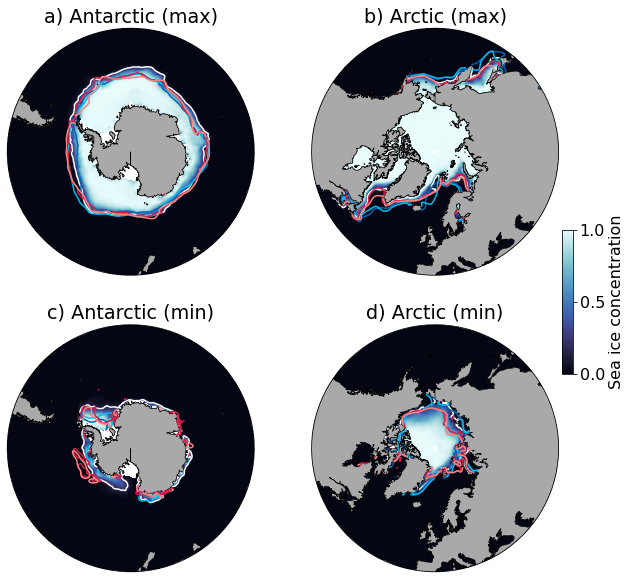

In [150]:
fig = plt.figure(figsize=(10,10))

#gs  = gridspec.GridSpec(6, 43, width_ratios=[1, 1, 0.05])#, hspace=0.2, wspace=0.15)

# a) Antarctic, max
ax = plt.subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
sc = SH_sic_obs_clim[8,...].plot.pcolormesh(transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1, add_colorbar=False)
SH_sic_obs_clim[8,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='w')
aice_CM2_025_SH_clim[8,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_CobaldBlue)
aice_CM2_1_SH_clim[8,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_SkyBlue)
aice_OM2_025_SH_clim[7,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Red)
aice_OM2_1_SH_clim[7,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Pink)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.title('a) Antarctic (max)')

# b) Arctic, max
ax = plt.subplot(2,2,2, projection=ccrs.NorthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
NH_sic_obs_clim[2,...].plot.pcolormesh(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1, add_colorbar=False)
NH_sic_obs_clim[2,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors='w')
aice_CM2_025_NH_clim[2,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_CobaldBlue)
aice_CM2_1_NH_clim[2,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_SkyBlue)
aice_OM2_025_NH_clim[2,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Red)
aice_OM2_1_NH_clim[2,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Pink)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.title('b) Arctic (max)')

# c) Antarctic, min
ax = plt.subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
SH_sic_obs_clim[1,...].plot.pcolormesh(transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1, add_colorbar=False)
SH_sic_obs_clim[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='w')
aice_CM2_025_SH_clim[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_CobaldBlue)
aice_CM2_1_SH_clim[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_SkyBlue)
aice_OM2_025_SH_clim[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Red)
aice_OM2_1_SH_clim[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Pink)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.title('c) Antarctic (min)')

# d) Arctic, min
ax = plt.subplot(2,2,4, projection=ccrs.NorthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
NH_sic_obs_clim[8,...].plot.pcolormesh(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1, add_colorbar=False)
NH_sic_obs_clim[8,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors='w')
aice_CM2_025_NH_clim[8,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_CobaldBlue)
aice_CM2_1_NH_clim[8,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_SkyBlue)
aice_OM2_025_NH_clim[8,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Red)
aice_OM2_1_NH_clim[8,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Pink)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.title('d) Arctic (min)')

# Colorbar
cbar_ax = fig.add_axes([0.9, 0.4, 0.015, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, ticks=np.arange(0,1.1,0.5))
cbar.set_label('Sea ice concentration')

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_sie_maps.png'
    plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight', facecolor='white');

---

### Calculate and save sea ice climatology

**CM2-025**

In [ ]:
%%time
aice_CM2_025 = cc.querying.getvar(expt_CM2_025, 'aice', session_CM2, frequency='1 monthly', start_time='0400-01-01', end_time='0500-01-31')
aice_CM2_025 = aice_CM2_025.sel(time=slice('0400-01-01', '0500-01-31'))
# shift time to make sure it is in the correct month
aice_CM2_025['time'] = aice_CM2_025.time.to_pandas() - timedelta(hours = 12) 
aice_CM2_025 = aice_CM2_025.sel(time=slice('0400-01-01', '0499-12-31'))

In [13]:
# change lat, lon names to match ocean model convention
aice_CM2_025.coords['ni'] = area_t025['xt_ocean'].values
aice_CM2_025.coords['nj'] = area_t025['yt_ocean'].values
aice_CM2_025 = aice_CM2_025.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

In [14]:
aice_CM2_025_NH = aice_CM2_025.sel(yt_ocean=slice(40, 90))
aice_CM2_025_SH = aice_CM2_025.sel(yt_ocean=slice(-90, -40))  

In [15]:
aice_CM2_025_SH_clim = aice_CM2_025_SH.groupby('time.month').mean('time', skipna=True)
aice_CM2_025_NH_clim = aice_CM2_025_NH.groupby('time.month').mean('time', skipna=True)

In [16]:
aice_CM2_025_SH_clim = aice_CM2_025_SH_clim.load()
aice_CM2_025_NH_clim = aice_CM2_025_NH_clim.load()

In [22]:
aice_CM2_025_NH_clim.to_netcdf(path_to_data + 'aice_CM2_025_NH_clim_400_499.nc')
aice_CM2_025_SH_clim.to_netcdf(path_to_data + 'aice_CM2_025_SH_clim_400_499.nc')

**OM2-025**

In [23]:
%%time
aice_OM2_025 = cc.querying.getvar(expt_OM2_025, 'aice_m', session_OM2, frequency='1 monthly', start_time='2300-01-01', end_time='2400-01-31')

CPU times: user 4min 56s, sys: 30.9 s, total: 5min 27s
Wall time: 15min 13s


In [24]:
aice_OM2_025 = aice_OM2_025.sel(time=slice('2300-01-01', '2400-01-31'))
aice_OM2_025['time'] = aice_OM2_025.time.to_pandas() - timedelta(hours = 12) # shift time to make sure it is in the correct month
aice_OM2_025 = aice_OM2_025.sel(time=slice('2300-01-01', '2399-12-31'))

In [26]:
aice_OM2_025.coords['ni'] = area_t025['xt_ocean'].values
aice_OM2_025.coords['nj'] = area_t025['yt_ocean'].values
aice_OM2_025 = aice_OM2_025.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

Extract SH and NH

In [28]:
aice_OM2_025_NH = aice_OM2_025.sel(yt_ocean=slice(40, 90))
aice_OM2_025_SH = aice_OM2_025.sel(yt_ocean=slice(-90, -40))  

Climatology

In [29]:
aice_OM2_025_SH_clim = aice_OM2_025_SH.groupby('time.month').mean('time', skipna=True)
aice_OM2_025_NH_clim = aice_OM2_025_NH.groupby('time.month').mean('time', skipna=True)

Load data

In [30]:
aice_OM2_025_SH_clim = aice_OM2_025_SH_clim.load()
aice_OM2_025_NH_clim = aice_OM2_025_NH_clim.load()

Save data

In [31]:
aice_OM2_025_NH_clim.to_netcdf(path_to_data + 'Comparison_ACCESS_OM2_025/aice_OM2_025_NH_clim_2300_2399.nc')
aice_OM2_025_SH_clim.to_netcdf(path_to_data + 'Comparison_ACCESS_OM2_025/aice_OM2_025_SH_clim_2300_2399.nc')

**OM2-1**

In [32]:
%%time
aice_OM2_1 = cc.querying.getvar(expt_OM2_1, 'aice_m', session_OM2, frequency='1 monthly', start_time='2300-01-01', end_time='2400-01-31')

CPU times: user 2min 47s, sys: 15.3 s, total: 3min 2s
Wall time: 7min 36s


In [33]:
aice_OM2_1 = aice_OM2_1.sel(time=slice('2300-01-01', '2400-01-31'))
aice_OM2_1['time'] = aice_OM2_1.time.to_pandas() - timedelta(hours = 12) # shift time to make sure it is in the correct month
aice_OM2_1 = aice_OM2_1.sel(time=slice('2300-01-01', '2399-12-31'))

In [34]:
aice_OM2_1.coords['ni'] = area_t1['xt_ocean'].values
aice_OM2_1.coords['nj'] = area_t1['yt_ocean'].values
aice_OM2_1 = aice_OM2_1.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

Extract SH and NH

In [35]:
aice_OM2_1_NH = aice_OM2_1.sel(yt_ocean=slice(40, 90))
aice_OM2_1_SH = aice_OM2_1.sel(yt_ocean=slice(-90, -40))  

Climatology

In [36]:
aice_OM2_1_SH_clim = aice_OM2_1_SH.groupby('time.month').mean('time', skipna=True)
aice_OM2_1_NH_clim = aice_OM2_1_NH.groupby('time.month').mean('time', skipna=True)

Load data

In [37]:
aice_OM2_1_SH_clim = aice_OM2_1_SH_clim.load()
aice_OM2_1_NH_clim = aice_OM2_1_NH_clim.load()

Save data

In [38]:
aice_OM2_1_NH_clim.to_netcdf(path_to_data + 'Comparison_ACCESS_OM2_1/aice_OM2_1_NH_clim_2300_2399.nc')
aice_OM2_1_SH_clim.to_netcdf(path_to_data + 'Comparison_ACCESS_OM2_1/aice_OM2_1_SH_clim_2300_2399.nc')

**CM2-1**

At the moment, only the ocean data from u-bz687 is in the database.

Direct access to data:
`/g/data/p73/archive/non-CMIP/ACCESS-CM2/bz687/history/ice`

In [19]:
import glob
path_sort = np.sort(glob.glob('/g/data/p73/archive/non-CMIP/ACCESS-CM2/bz687/history/ice/iceh_d.04*.nc'))

In [94]:
# Load in first month
aice_tmp = xr.open_dataset('/g/data/p73/archive/non-CMIP/ACCESS-CM2/bz687/history/ice/iceh_d.0400-01.nc').aice
# Monthly average, offline
aice_bz687 = aice_tmp.mean('time')
# Add time information (first entry in month)
aice_bz687.expand_dims(dim={"time": np.arange(1)}, axis=0)
aice_bz687['time'] = aice_tmp.time[0]

# Now repeat for remaining months and concatenate along time dimension
for i in range(1, len(path_sort)):
    aice_tmp = xr.open_dataset(path_sort[i]).aice
    aice_tmp_mean = aice_tmp.mean('time')
    aice_tmp_mean.expand_dims(dim={"time": np.arange(1)}, axis=0)
    aice_tmp_mean['time'] = aice_tmp.time[0]
    
    aice_bz687 = xr.concat([aice_bz687, aice_tmp_mean], dim='time')

Update coordinates to match ocean grid

In [95]:
aice_bz687.coords['ni'] = area_t1['xt_ocean'].values
aice_bz687.coords['nj'] = area_t1['yt_ocean'].values
aice_bz687 = aice_bz687.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

Extract SH and NH

In [96]:
aice_CM2_1_NH = aice_bz687.sel(yt_ocean=slice(40, 90))
aice_CM2_1_SH = aice_bz687.sel(yt_ocean=slice(-90, -40))  

Climatology

In [99]:
aice_CM2_1_SH_clim = aice_CM2_1_SH.groupby('time.month').mean('time', skipna=True)
aice_CM2_1_NH_clim = aice_CM2_1_NH.groupby('time.month').mean('time', skipna=True)

Load data

In [103]:
aice_CM2_1_SH_clim = aice_CM2_1_SH_clim.load()
aice_CM2_1_NH_clim = aice_CM2_1_NH_clim.load()

Save data

In [104]:
aice_CM2_1_NH_clim.to_netcdf(path_to_data + 'Comparison_ACCESS_CM2_1/aice_CM2_1_NH_clim_400_499.nc')
aice_CM2_1_SH_clim.to_netcdf(path_to_data + 'Comparison_ACCESS_CM2_1/aice_CM2_1_SH_clim_400_499.nc')

---
Load CMIP6 data

In [7]:
import intake
cat = intake.cat.nci
#cat = intake.open_catalog('/g/data/hh5/public/apps/nci-intake-catalogue/catalogue.yaml')
cmip6 = cat['esgf'].cmip6  # only works with  conda env:analysis3-22.07 (newer version has something changed)
# subset = cmip6.search(experiment_id = ['historical'],  
#                       member_id = 'r1i1p1f1', table_id = ['Amon'], #monthly averages
#                       source_id='ACCESS-CM2') 

# values_dict = subset.unique()
# values_dict['variable_id'] # This will print the list of variables in the subset

In [2]:
subset = cmip6.search(activity_id='CMIP', experiment_id='1pctCO2', source_id='ACCESS-CM2', member_id='r1i1p1f1', table_id='SImon', variable_id='siareas')

In [3]:
subset.keys()

dict_keys(['CMIP6.CMIP.CSIRO-ARCCSS.ACCESS-CM2.1pctCO2.r1i1p1f1.SImon.siareas.gn.v20200817'])

In [5]:
subset_n = cmip6.search(activity_id='CMIP', experiment_id='1pctCO2', source_id='ACCESS-CM2', member_id='r1i1p1f1', table_id='SImon', variable_id='siarean')

In [6]:
subset_n.keys()

dict_keys(['CMIP6.CMIP.CSIRO-ARCCSS.ACCESS-CM2.1pctCO2.r1i1p1f1.SImon.siarean.gn.v20200817'])

In [ ]:
dset = subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version'


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full nump

In [8]:
dset

{'CMIP6.CMIP.CSIRO-ARCCSS.ACCESS-CM2.1pctCO2.r1i1p1f1.SImon.siareas.gn.v20200817': <xarray.Dataset>
 Dimensions:    (time: 1800, bnds: 2)
 Coordinates:
   * time       (time) object 0950-01-16 12:00:00 ... 1099-12-16 12:00:00
 Dimensions without coordinates: bnds
 Data variables:
     time_bnds  (time, bnds) object dask.array<chunksize=(1800, 2), meta=np.ndarray>
     siareas    (time) float32 dask.array<chunksize=(1800,), meta=np.ndarray>
 Attributes: (12/48)
     Conventions:             CF-1.7 CMIP-6.2
     activity_id:             CMIP
     branch_method:           standard
     branch_time_in_child:    0.0
     branch_time_in_parent:   0.0
     creation_date:           2020-08-17T02:04:03Z
     ...                      ...
     version:                 v20200817
     license:                 CMIP6 model data produced by CSIRO is licensed u...
     cmor_version:            3.4.0
     tracking_id:             hdl:21.14100/e56869b8-b303-4633-baae-ba92607b16e4
     intake_esm_varname:

In [10]:
siareas = dset['CMIP6.CMIP.CSIRO-ARCCSS.ACCESS-CM2.1pctCO2.r1i1p1f1.SImon.siareas.gn.v20200817']

In [45]:
test = siareas.siareas.sel(time=slice('0800-01-01','0899-12-31'))

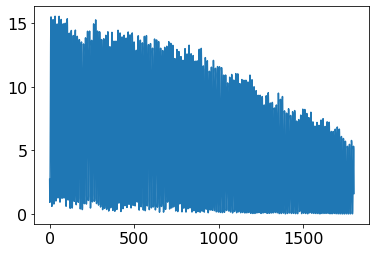

In [53]:
plt.plot(siareas.siareas.values)

In [51]:
siareas.siareas.time

<xarray.DataArray 'time' (time: 1800)>
array([cftime.DatetimeProlepticGregorian(950, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(950, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(950, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(1099, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1099, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1099, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0950-01-16 12:00:00 ... 1099-12-16 12:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [42]:
aice_CM2_025_NH_clim

<xarray.DataArray 'aice' (month: 12, yt_ocean: 407, xt_ocean: 1440)>
[7032960 values with dtype=float32]
Coordinates:
    TLON      (yt_ocean, xt_ocean) float32 ...
    TLAT      (yt_ocean, xt_ocean) float32 ...
    ULON      (yt_ocean, xt_ocean) float32 ...
    ULAT      (yt_ocean, xt_ocean) float32 ...
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 40.13 40.32 40.51 40.7 ... 89.74 89.84 89.95
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/i...
    contact:        Martin Dix
    email:          martin.dix@csiro.au
    created:        2021-11-30
    description:    ACCESS-CM2 with n96 atmosphere coupled to COSIMA OM2 0.25...
    url:            https://code.metoffice.gov.uk/svn/roses-u/c/j/8/7/7/trunk

In [43]:
test_OM2_1 = cc.querying.getvar(expt_OM2_1, 'aice_m', session_OM2, frequency='1 monthly', start_time='2399-01-01', end_time='2400-01-31')

In [44]:
test_OM2_1

<xarray.DataArray 'aice_m' (time: 14, nj: 300, ni: 360)>
dask.array<concatenate, shape=(14, 300, 360), dtype=float32, chunksize=(1, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2399-01-01 00:00:00 ... 2400-02-01 00:00:00
    TLON     (nj, ni) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/ik11/outputs/access-om2/1deg_jra55_ryf9091_gadi...
    contact:        Ryan Holmes
    email:          ryan.holmes@unsw.edu.au
    created:        2020-02-01
    description:    1 degree ACCESS-OM2 global model configuration under 1990...

In [54]:
subset_siconc = cmip6.search(activity_id='CMIP', experiment_id='1pctCO2', source_id='ACCESS-CM2', member_id='r1i1p1f1', table_id='SImon', variable_id='siconc')

In [55]:
subset_siconc.keys()

dict_keys(['CMIP6.CMIP.CSIRO-ARCCSS.ACCESS-CM2.1pctCO2.r1i1p1f1.SImon.siconc.gn.v20200817'])

In [56]:
dset_siconc = subset_siconc.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version'


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full nump

In [57]:
siconc = dset_siconc['CMIP6.CMIP.CSIRO-ARCCSS.ACCESS-CM2.1pctCO2.r1i1p1f1.SImon.siconc.gn.v20200817']

In [63]:
out = siconc.sel(time=slice('0955-01-01','0958-12-31'))

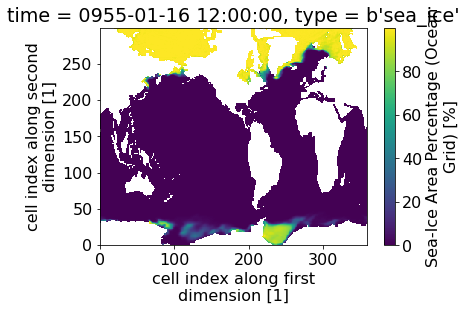

In [66]:
out.siconc[0,...].plot()

In [9]:
# Which experiments are available for ACCESS-CM2?
subset = cmip6.search(activity_id='CMIP', source_id='ACCESS-CM2', member_id='r1i1p1f1', table_id='SImon', variable_id='siconc')

In [12]:
subset.keys()#.experiment_id

dict_keys(['CMIP6.CMIP.CSIRO-ARCCSS.ACCESS-CM2.1pctCO2.r1i1p1f1.SImon.siconc.gn.v20200817', 'CMIP6.CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.r1i1p1f1.SImon.siconc.gn.v20200817', 'CMIP6.CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.r1i1p1f1.SImon.siconc.gn.v20200817', 'CMIP6.CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.r1i1p1f1.SImon.siconc.gn.v20200817'])

---

Some old plot: Concentration maps

In [103]:
geolon_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

In [105]:
aice_CM2_025_NH_clim = aice_CM2_025_NH_clim.assign_coords({'geolon_t': geolon_t.sel(yt_ocean=slice(45,90)), 'geolat_t': geolat_t.sel(yt_ocean=slice(45,90))})
NH_obs_clim = NH_obs_clim.assign_coords({'geolon_t': geolon_t.sel(yt_ocean=slice(-90,-45)), 'geolat_t': geolat_t.sel(yt_ocean=slice(-90,-45))})

In [87]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.455
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

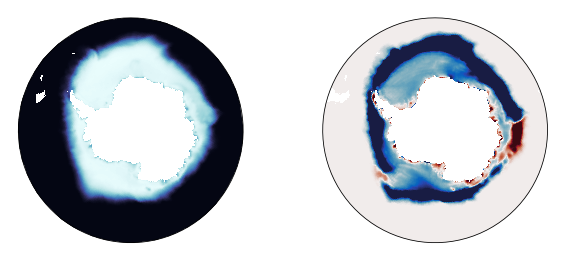

In [98]:
fig = plt.figure(figsize=(10,10))

ax = plt.subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.pcolormesh(SH_obs_clim.xt_ocean, SH_obs_clim.yt_ocean, SH_obs_clim[8,...], transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1)

ax = plt.subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.pcolormesh(SH_obs_clim.xt_ocean, SH_obs_clim.yt_ocean, aice_CM2_025_SH_clim[8,...]-SH_obs_clim[8,...], transform=ccrs.PlateCarree(), cmap=cm.cm.balance, vmin=-0.2, vmax=0.2)